---
## Step one: load the required libraries

In [231]:
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import when, col
from pyspark.ml.feature import (
    Bucketizer,
    OneHotEncoder,
    StringIndexer, 
)
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
)
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
    RegressionEvaluator,
)

from pyspark.ml.feature import (
    StringIndexer,
    VectorAssembler,
)
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import (
    BinaryClassificationMetrics,
    MulticlassMetrics, 
)
from pyspark.mllib.linalg import DenseMatrix
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create Spark session
spark = SparkSession.builder\
    .appName("census_data") \
    .getOrCreate()
# Set the logging level to ERROR
spark.sparkContext.setLogLevel("ERROR")
nltk.download('wordnet', quiet=True)

True

## Step Two: load the data

In [232]:
data = spark.read.csv(
    "adult.csv", 
    escape='"',
    header=True, 
    inferSchema=True,
)


## Step Three: Explore the data

Doing some basic exploration of the data to start understanding the data and what it looks like.

In [233]:
print("Data schema:")
data.printSchema()
print("\nData row sample:")
data.show(10)
print(f"\nNumber of rows in data: {data.count()}")
print(f"Number of columns in data: {len(data.columns)}")

machine_names = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'native-country',
]
for name in machine_names:
    print(f"\n{name} column value counts (sorted):")
    data.groupBy(name).count().orderBy('count', ascending=False).show()

# Create a temporary view of the data
data.createOrReplaceTempView("data_view")

# SQL query to select rows that have ? in any column
query = "SELECT * FROM data_view WHERE " + " OR ".join([f"`{col}` = '?'" for col in data.columns])
data_with_question = spark.sql(query)

# Print the count of unique rows
print(f"Count of unique rows with ?: {data_with_question.distinct().count()}")


Data schema:
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)


Data row sample:
+---+----------------+------+------------+---------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|   education|educational-num|    marital-status|       occupation| relationship| race|gender|capital-gain|capital-lo

## Step Four: Clean the data

Try to find the missing values and replace them with the mean or common values of the column they belong to.

In [234]:
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
numerical_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Replace ? with the mode for categorical columns
for col_name in categorical_cols:
    mode = data.filter(data[col_name] != '?').groupBy(col_name).count().orderBy('count', ascending=False).first()[0]
    data = data.withColumn(col_name, when(col(col_name) == '?', mode).otherwise(col(col_name)))

# Replace ? with the mean for numerical columns
for col_name in numerical_cols:
    mean_value = data.filter(data[col_name] != '?').select(col_name).agg({col_name: 'mean'}).first()[0]
    data = data.withColumn(col_name, when(col(col_name) == '?', mean_value).otherwise(col(col_name)))


## Step Five: Feature Engineering

Turn categorical variables into vectorized representations to be used for training.

In [235]:
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec") for col in categorical_cols]

pipeline = Pipeline(stages=indexers + encoders)
data = pipeline.fit(data).transform(data)


## Step Six: Train and Explore ML algorithms models


### Logistic Regression with all features
This test is giving all features to the model and see how it performs.

In [236]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

target_indexer = StringIndexer(inputCol='income', outputCol='label')
target_indexer_model = target_indexer.fit(train_data)
train_data = target_indexer_model.transform(train_data)

features = [f"{col}_vec" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=features, outputCol="features")

lr = LogisticRegression(featuresCol='features', labelCol='label')

pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(train_data)


In [237]:
# Index the categorical target column income to numerical labels named label.
target_indexer = StringIndexer(inputCol='income', outputCol='label')

# Checking here to see already exists in train_data, if so, drop it.
# might just been specific to issues becasue of the way the data was loaded.
if 'label' in train_data.columns:
    train_data = train_data.drop('label')

# Fit the target_indexer on the train_data and transform it
target_indexer_model = target_indexer.fit(train_data)
train_data = target_indexer_model.transform(train_data)

# Prepare the feature columns for vectorization
features = [f"{col}_vec" for col in categorical_cols] + numerical_cols

# Assemble the features into a single vector column named features
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Create a logistic regression classifier
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Create a pipeline with the assembler and logistic regression stages
pipeline = Pipeline(stages=[assembler, lr])

# Fit the pipeline on the train_data to train the logistic regression model
model = pipeline.fit(train_data)

# Same as above.
if 'label' in test_data.columns:
    test_data = test_data.drop('label')

# Transform the test_data using the trained target_indexer_model
test_data = target_indexer_model.transform(test_data)

# Make predictions on test_data using the trained model
predictions = model.transform(test_data)

# Evaluate the model's performance on test data using accuracy metric
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

# Convert DataFrame to RDD and prepare for BinaryClassificationMetrics
predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda r: (float(r[0]), float(r[1])))

# Instantiate metrics object for binary classification
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Calculate precision, recall, and F1 score
precision = metrics.areaUnderPR
recall = metrics.areaUnderROC
f1Score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Evaluate Area Under ROC
binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc_roc = binary_evaluator.evaluate(predictions)

# Evaluate Area Under PR
binary_evaluator.setMetricName("areaUnderPR")
auc_pr = binary_evaluator.evaluate(predictions)

# Print the evaluation metrics
print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1Score}")
print(f"Area Under ROC: {auc_roc}")
print(f"Area Under PR: {auc_pr}")


/home/jeff/utk/COSC526/cosc526_final/.venv/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy = 0.8484442612816815
Precision = 0.6315601305232993
Recall = 0.7613199651631117
F1 Score = 0.6903958755063706
Area Under ROC: 0.9001612917399779
Area Under PR: 0.7619099963778427


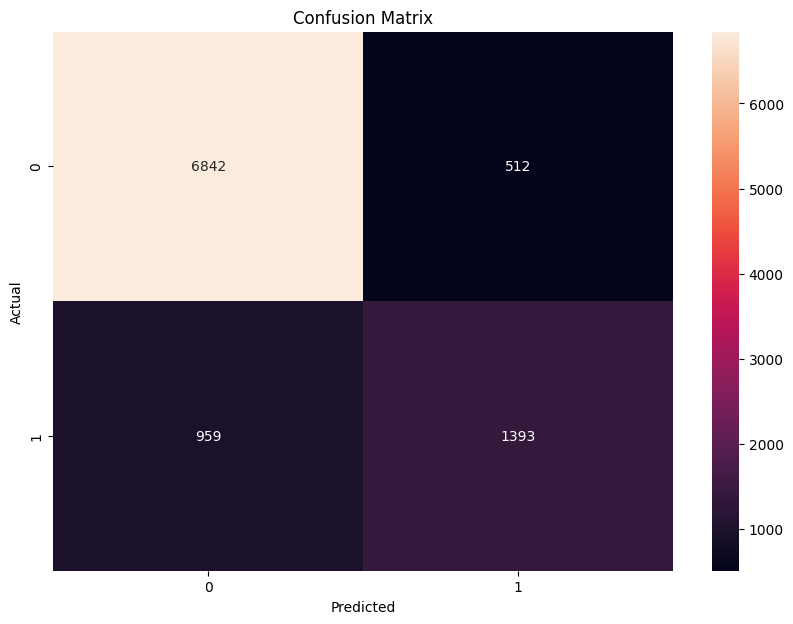

In [238]:
# MulticlassMetrics object to compute metrics based on predictions and labels,
metrics = MulticlassMetrics(predictions.select('prediction', 'label').rdd)

confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()


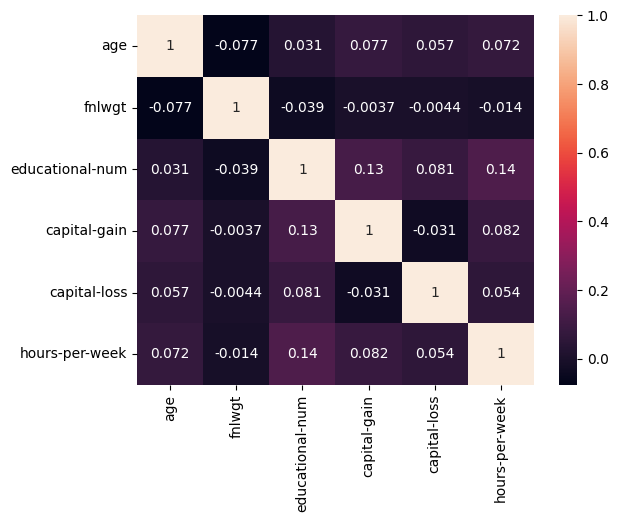

In [239]:
# Only numeric columns.
numeric_data = data.select(numerical_cols)
data_pd = numeric_data.toPandas()

corr_matrix = data_pd.corr()

sns.heatmap(corr_matrix, annot=True)
plt.show()


### Random Forest Classifier for Age

In [240]:
# The features column reused, remove age from numerical_cols.
new_numerical_cols = [col for col in numerical_cols if col != 'age']

new_features = [f"{col}_vec" for col in categorical_cols] + new_numerical_cols
new_assembler = VectorAssembler(inputCols=new_features, outputCol="new_features")

# Random Forest Regressor.
rf = RandomForestRegressor(featuresCol='new_features', labelCol='age')

new_pipeline = Pipeline(stages=[new_assembler, rf])

# Fit the model.
new_model = new_pipeline.fit(train_data)

# Transform the test data.
predictions = new_model.transform(test_data)

# Root Mean Squared Error.
evaluator = RegressionEvaluator(labelCol="age", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error = {rmse}")

# Mean Absolute Error.
evaluator = RegressionEvaluator(labelCol="age", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error = {mae}")

# R-Squared.
evaluator = RegressionEvaluator(labelCol="age", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R-Squared = {r2}")


Root Mean Squared Error = 10.436708474443677


Mean Absolute Error = 8.142774897621958
R-Squared = 0.40880761653574205


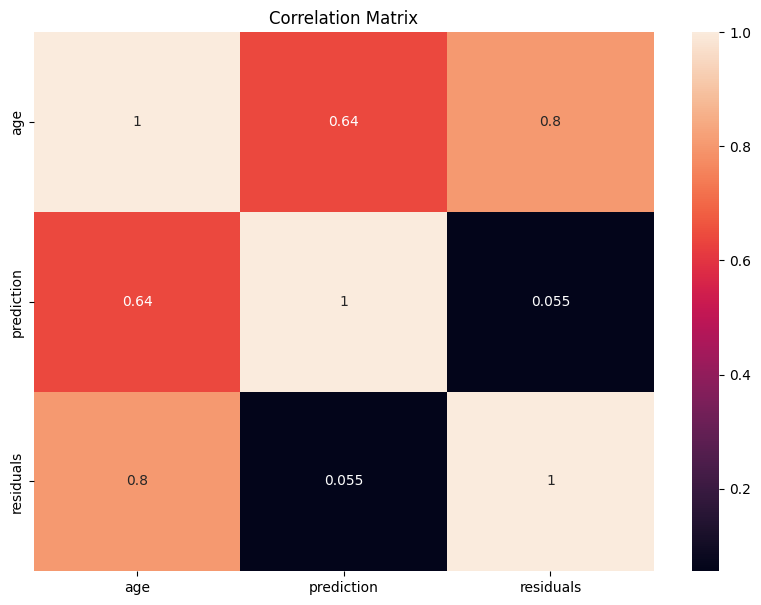

In [241]:
predictions_pd = predictions.select("age", "prediction").toPandas()

predictions_pd["residuals"] = predictions_pd["age"] - predictions_pd["prediction"]
correlation_matrix = predictions_pd.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

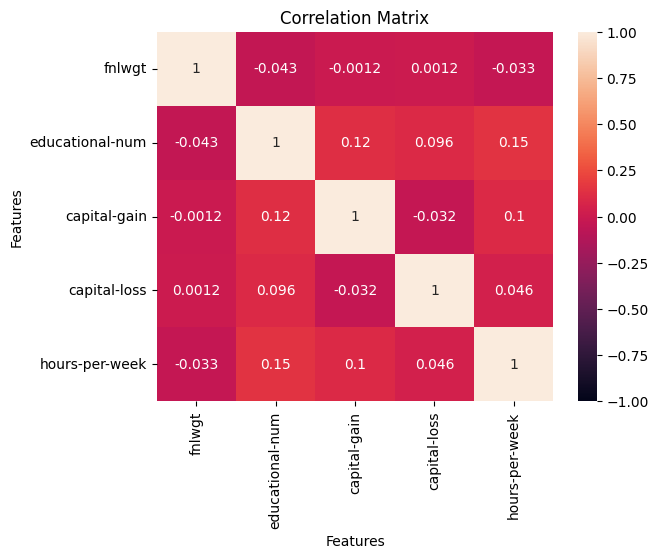

In [242]:
numeric_test_data = test_data.select(new_numerical_cols)
numeric_test_data_pd = numeric_test_data.toPandas()
corr_matrix = numeric_test_data_pd.corr()

sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.xlabel("Features")
plt.ylabel("Features")
plt.title("Correlation Matrix")
plt.show()

### Random Forest Classifier with Ages bucketed.

In [243]:
# splits for age buckets
splits = [-float("inf"), 20, 30, 40, 50, 60, 70, 80, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="age", outputCol="age_bucket")

# Add to the data.
data = bucketizer.setHandleInvalid("keep").transform(data)

# Split the data again.
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- workclass_index: double (nullable = false)
 |-- education_index: double (nullable = false)
 |-- marital-status_index: double (nullable = false)
 |-- occupation_index: double (nullable = false)
 |-- relationship_index: double (nullable = false)
 |-- race_index: double (nullable = false)
 |-- native-country_index: double (nullable = false)
 |-- workclass_vec

In [244]:
# remove age
new_numerical_cols = [col for col in numerical_cols if col != 'age']

new_features = [f"{col}_vec" for col in categorical_cols] + new_numerical_cols
new_assembler = VectorAssembler(inputCols=new_features, outputCol="new_features")

# RandomForestClassifier
rf = RandomForestClassifier(featuresCol='new_features', labelCol='age_bucket', numTrees=100)

new_pipeline = Pipeline(stages=[new_assembler, rf])

new_model = new_pipeline.fit(train_data)
predictions = new_model.transform(test_data)

# evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="age_bucket", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
reg_evaluator = RegressionEvaluator(labelCol="age_bucket", predictionCol="prediction", metricName="rmse")
rmse = reg_evaluator.evaluate(predictions)

# print scores.
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"RMSE: {rmse}")


Accuracy: 0.40603750257572635
Precision: 0.41930963979906255
Recall: 0.40603750257572635
F1 Score: 0.35627745015169854
RMSE: 1.3021325373627872


/home/jeff/utk/COSC526/cosc526_final/.venv/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


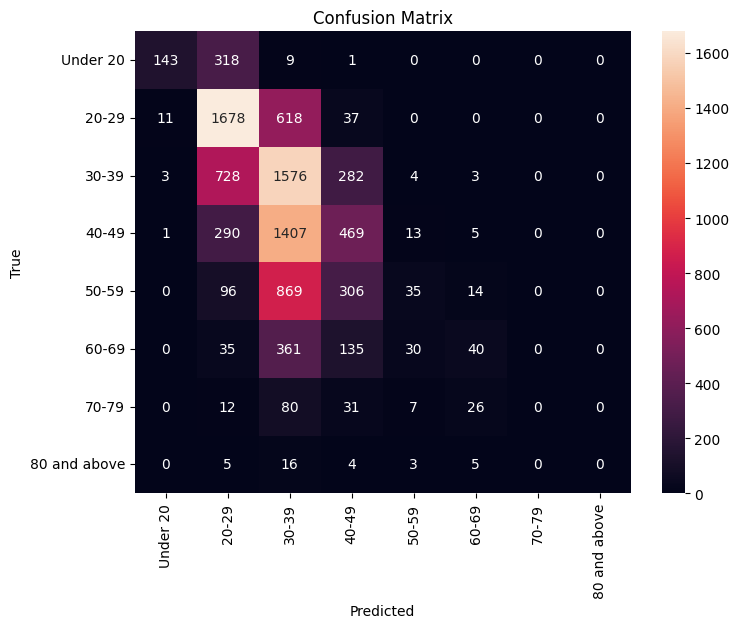

In [245]:
# Was throwing error this fixed.
predictions = predictions.withColumn("prediction", col("prediction").cast("double"))
predictions_and_labels = predictions.select("prediction", "age_bucket").rdd
metrics = MulticlassMetrics(predictions_and_labels)
confusion_matrix = metrics.confusionMatrix()

# Better age bucket labels based on age ranges.
age_bucket_labels = [
    "Under 20",     # 0: -inf to 20
    "20-29",        # 1: 20 to 29
    "30-39",        # 2: 30 to 39
    "40-49",        # 3: 40 to 49
    "50-59",        # 4: 50 to 59
    "60-69",        # 5: 60 to 69
    "70-79",        # 6: 70 to 79
    "80 and above"  # 7: 80 to inf
]

confusion_matrix_np = confusion_matrix.toArray()
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_np, annot=True, fmt=".0f",
            xticklabels=age_bucket_labels,
            yticklabels=age_bucket_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


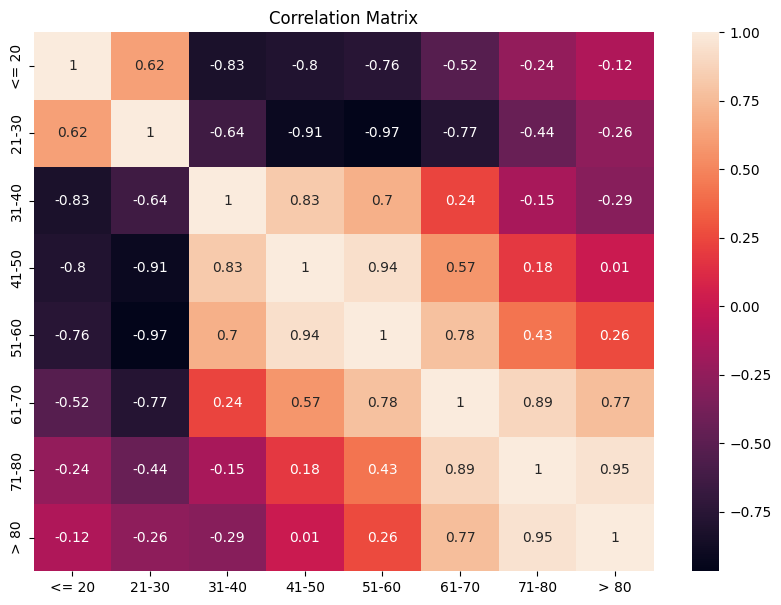

In [246]:
probabilities = predictions.select("probability")
# Define the bucket labels based on age ranges
bucket_labels = ["<= 20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "> 80"]
# Convert probabilities to feature vector
assembler = VectorAssembler(inputCols=probabilities.columns, outputCol="features")
assembled_data = assembler.transform(probabilities).select("features")
correlation_matrix = Correlation.corr(assembled_data, "features").collect()[0][0].toArray()
# Plot correlation matrix with bucket labels
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, xticklabels=bucket_labels, yticklabels=bucket_labels)
plt.title("Correlation Matrix")
plt.show()


## Step Seven: Visualize the results